# **Contextual Embedding**

Generalist embeddings are popular for working with any type of data. However, they may not work optimally in specific applications.
Nowadays it is possible to build contextual embeddings that perform better, but require more computational power and resources.
In this subsection we will see how to train an embedding with a public dataset and we will test its performance.

In [1]:
# Libraries
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec,KeyedVectors
from gensim.test.utils import datapath
import re
import unicodedata
from tqdm import tqdm
import gensim
import multiprocessing
import random
from gensim.models.phrases import Phrases, Phraser
nltk.download('stopwords')
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import multiprocessing
import json
import pandas as pd



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


First we downloaded and decompressed the training dataset of the MESINESP (MEdical Semantic Indexing in Spanish) Task. This dataset is composed of a set of abstracts of scientific articles extracted from repositories in Spanish.

In [2]:
!wget https://zenodo.org/record/5602914/files/Subtrack1-Scientific_Literature.zip?download=1
!unzip /content/Subtrack1-Scientific_Literature.zip?download=1

--2022-10-03 16:14:33--  https://zenodo.org/record/5602914/files/Subtrack1-Scientific_Literature.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222445275 (212M) [application/octet-stream]
Saving to: ‘Subtrack1-Scientific_Literature.zip?download=1’

Subtrack1-Scientifi 100%[===================>] 212.14M  15.2MB/s    in 16s     

2022-10-03 16:14:50 (13.6 MB/s) - ‘Subtrack1-Scientific_Literature.zip?download=1’ saved [222445275/222445275]

Archive:  /content/Subtrack1-Scientific_Literature.zip?download=1
   creating: Subtrack1-Scientific_Literature/
   creating: Subtrack1-Scientific_Literature/Development/
  inflating: Subtrack1-Scientific_Literature/Development/development_set_subtrack1.json  
   creating: Subtrack1-Scientific_Literature/Test/
  inflating: Subtrack1-Scientific_Literature/Test/test_set_subtrack1.json  
   creating: Subtrack1

We then load the *.json file into a dictionary, and iterate through each item in the list taking the "abstractText" field, which contains the abstract of each item.
To speed up the calculation process, we will only work with the first 2500 items (the corpus has more than 200000).

In [3]:
with open("/content/Subtrack1-Scientific_Literature/Train/training_set_subtrack1_only_articles.json", 'r') as f:
  biomed_dict = json.load(f)

documentos = [doc["abstractText"] for doc in biomed_dict["articles"]][:2500]

We create the ``clean_data`` function that will preprocess an input document: it will convert to lowercase, replace digits with spaces, tokenize, remove stopwords and remove tokens less than or equal to 2 characters.

In [4]:
stopwords_list=stopwords.words('spanish')
def clean_data(w):
    w = w.lower()
    w=re.sub(r'[^\w\s]','',w)
    w=re.sub(r"([0-9])", r" ",w)
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words)

In [5]:
def get_inp(documentos):
    sent=list(map(clean_data,documentos))
    for lines in tqdm(sent):
        yield lines.split()


We apply function on documents:

In [6]:
sent = [row for row in get_inp(documentos)]

100%|██████████| 2500/2500 [00:00<00:00, 66410.96it/s]


We train the Phrases model of gensim to detect bigrams present in our data. In this case we will consider token sets that appear at least 20 times in our corpus.
In addition, we use the Phraser method to improve the performance of Gensim in subsequent steps.

In [7]:
phrases = Phraser(Phrases(sent, min_count=20, progress_per=10000))

We apply the model to our data set:

In [8]:
sentences = phrases[sent]

In the index document 3, it can be seen that it has been successfully applied. The term "primary_care" is the union of the tokens "care" and "primary" which appeared continuously on at least 20 occasions within the corpus

In [9]:
sentences[3]

['introducción',
 'pandemia',
 'ocasionada',
 'sarscov',
 'supuesto',
 'reestructuración',
 'precedentes',
 'asistencia',
 'sanitaria',
 'centros',
 'salud',
 'objetivo_conocer',
 'percepciones',
 'personal',
 'médico',
 'centro',
 'salud',
 'albaycín',
 'respuesta',
 'equipo',
 'atención_primaria',
 'pandemia',
 'covid',
 'meses',
 'marzo',
 'abril',
 'métodos_estudio',
 'cualitativo',
 'observacional',
 'orientación',
 'fenomenológica',
 'mediante',
 'entrevistas',
 'individuales',
 'ámbito',
 'estudio',
 'centro',
 'salud',
 'albaycín',
 'saturación',
 'teórica',
 'determinó',
 'tamaño',
 'muestra',
 'totalidad',
 'plantilla',
 'médica',
 'llevó_cabo',
 'análisis',
 'narrativo',
 'contenido',
 'resultados',
 'discursos',
 'muestran',
 'seis',
 'categorías',
 'análisis',
 'organización',
 'toma',
 'decisiones',
 'características',
 'respuesta',
 'dada',
 'mantenimiento',
 'pilares',
 'atención_primaria',
 'cualidades',
 'equipo',
 'potenciadas',
 'rol',
 'docencia',
 'nuevas',
 'diná

Once the corpus is prepared, we will proceed with the training of the Word2Vec model. To do so, we will use the multiprocessor capabilities of Gensim and we will use some typical parameters for this type of model.
In the CBOW training strategy specified in the Word2Vec paper, windows of size N are taken from each document. Then, the core word is extracted from the windowing and a model capable of predicting that core word from the rest (the context) is trained.
The term "window" indicates the window size chosen to subdivide each of our documents. The function is in charge of transforming the whole corpus (train/test, transformation of the words into vectors, backprogataion...), but at the end you will have internally the following data format:

In [10]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20, 
                     workers=cores-1)

Once the Word2Vec object is created, we proceed to generate a vocabulary for embedding, which will be extracted from our corpus.

In [11]:
w2v_model.build_vocab(sentences, progress_per=10000)

Finally, we proceed to train the embedding, and then save it (and load it to verify that it has been applied correctly).

In [12]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(2111923, 7027980)

In [13]:
w2v_model.wv.save_word2vec_format("guardar.bin",binary=True)
saved_model_path='/content/guardar.bin'
trained_model = KeyedVectors.load_word2vec_format(saved_model_path, binary=True)


We proceed to see how embedding works by looking for synonyms to some example words present in the corpus.

In [14]:
trained_model.wv.most_similar(positive=["virus"], topn=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('inmunodeficiencia', 0.9801391363143921),
 ('hepatitis', 0.9197874069213867),
 ('humana', 0.9117758274078369)]

In [15]:
trained_model.wv.most_similar(positive=["vph"], topn=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('hepatitis', 0.8914619088172913),
 ('adn', 0.8741940855979919),
 ('infectados', 0.8681755661964417),
 ('virus', 0.865944504737854),
 ('bacterias', 0.85655277967453),
 ('agente', 0.8511638641357422),
 ('negativos', 0.8392640352249146),
 ('vih', 0.8322026133537292),
 ('infección', 0.8321731090545654),
 ('infección_vih', 0.8261106014251709)]

In [16]:
print(trained_model.similarity('virus', 'covid'))

0.6285719


Another option is to visualize the embedding, to see if similar words are close to each other. To do this, we are going to extract the vocabulary from the model and introduce in a matrix X the vectors of all the words

In [17]:
vocab = list(trained_model.wv.vocab.keys())
X = trained_model.wv[vocab]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


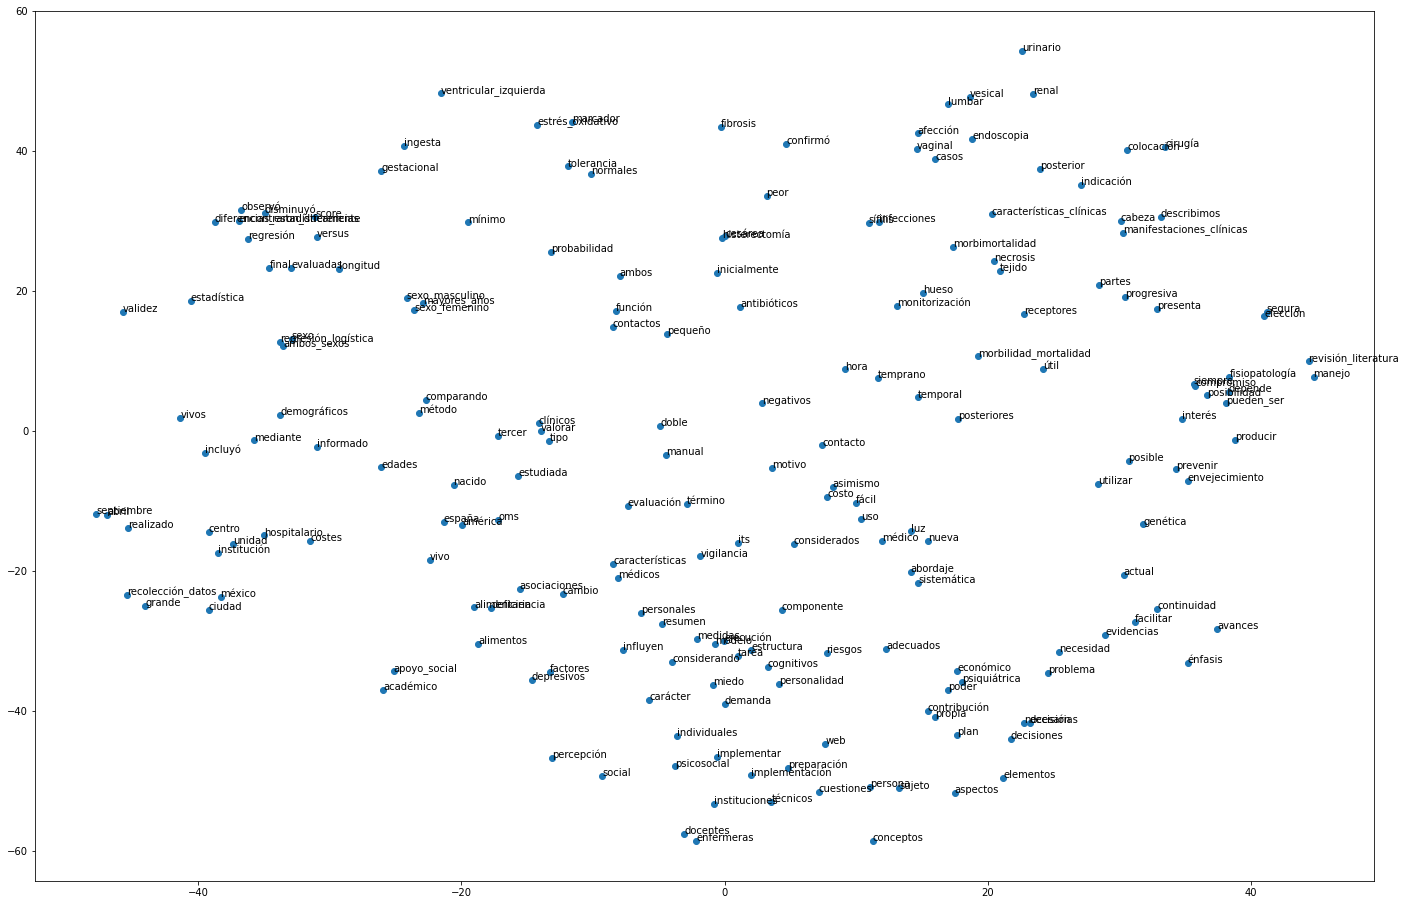

In [19]:
df_2 = df.sample(200)

fig = plt.figure(figsize=(24,16))

ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_2['x'], df_2['y'])

for word, pos in df_2.iterrows():
    ax.annotate(word, pos)